In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\joris\\Documents\\eScience_data\\data'
sys.path.insert(0, ROOT)
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")

### Import pre-processed dataset "AllPositive"

In [2]:
import time
import pickle

#loading data as pickled object goes a lot quicker
outfile = os.path.join(path_data, 'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle')

print(outfile)
start = time.time()
with open(outfile, 'rb') as inf:
        spectrums = pickle.load(inf)
end = time.time()
print('loading took {:.2f} s'.format(end-start))

C:\Users\joris\Documents\eScience_data\data\gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle
loading took 11.15 s


### Import spec2vec matches of 1,000 spectra where their inchikeys occur >=5 times in the library

In [3]:
import pickle
outfile = os.path.join(path_data, 'found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        found_matches_s2v = pickle.load(inf)
else:
    print('error')
    
#contains info on the query/library
outfile = os.path.join(path_data, 'documents_query_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        documents_query_s2v = pickle.load(inf)

outfile = os.path.join(path_data, 'documents_library_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        documents_library_s2v = pickle.load(inf)

C:\Users\joris\Documents\eScience_data\data\found_matches_s2v.pickle
C:\Users\joris\Documents\eScience_data\data\documents_query_s2v.pickle
C:\Users\joris\Documents\eScience_data\data\documents_library_s2v.pickle


### Calculate pairwise tanimoto similarity between top 20 results for each query

In [77]:
import pickle
from rdkit import Chem, DataStructs

outfile = os.path.join(path_data, 'similarity_matrices_test_set1.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        similarity_matrices = pickle.load(inf)
else:
    #for each matches df make a similarity matrix based on tanimoto
    similarity_matrices = []
    topn = 20

    for ID in range(len(found_matches_s2v)):
        df = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
        library_ids = df.index.values
        rows = []
        for lib_id_i in library_ids:
            smiles_i = documents_library_s2v[lib_id_i]._obj.get("smiles")

            if not smiles_i or smiles_i == "None": # check that lib_id_i smiles exist
                rows.append([0] * len(library_ids)) #default to all 0 if it doesnt exist
                continue
            ms_i = Chem.MolFromSmiles(smiles_i)
            if not ms_i: #in case something is wrong with smiles
                rows.append([0] * len(library_ids)) #default to all 0 if it doesnt exist
                continue
            fp_i = Chem.RDKFingerprint(ms_i)

            row = []
            for lib_id_j in library_ids:
                smiles_j = documents_library_s2v[lib_id_j]._obj.get("smiles")

                if smiles_j and smiles_j != "None":
                    ms_j = Chem.MolFromSmiles(smiles_j)
                    if ms_j:
                        fp_j = Chem.RDKFingerprint(ms_j)
                        score = DataStructs.FingerprintSimilarity(fp_i, fp_j)
                    else: #in case something is wrong with smiles
                        score = 0
                else: #in case it doesnt have smiles
                    score = 0
                row.append(score)

            rows.append(row)
        similarity_matrices.append(pd.DataFrame(rows))
    #write to file    
    with open(outfile, 'wb') as outf:
        pickle.dump(similarity_matrices, outf)

C:\Users\joris\Documents\eScience_data\data\similarity_matrices_test_set1.pickle


In [97]:
#corrected version where true matches get a slightly higher value in the diagonal
import pickle
cor_val = 1.001
outfile = os.path.join(path_data, 'similarity_matrices_corrected_test_set1.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        similarity_matrices_cor = pickle.load(inf)
else:
    #for each matches df make a similarity matrix based on tanimoto
    similarity_matrices_cor = []
    topn = 20

    for ID in range(len(found_matches_s2v)):
        df = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
        library_ids = df.index.values
        rows = []
        for lib_id_i in library_ids:
            smiles_i = documents_library_s2v[lib_id_i]._obj.get("smiles")

            if not smiles_i or smiles_i == "None": # check that lib_id_i smiles exist
                rows.append([0] * len(library_ids)) #default to all 0 if it doesnt exist
                continue
            ms_i = Chem.MolFromSmiles(smiles_i)
            if not ms_i: #in case something is wrong with smiles
                rows.append([0] * len(library_ids)) #default to all 0 if it doesnt exist
                continue
            fp_i = Chem.RDKFingerprint(ms_i)

            row = []
            for lib_id_j in library_ids:
                if lib_id_i == lib_id_j: #if diagonal see if its a true match and give it a slightly higher value for plotting
                    df_select = found_matches_s2v_match_perc_pmass_sim[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
                    if df_select.loc[lib_id_j]['label'] == 1:
                        score = cor_val
                    else:
                        score = 1
                    
                else:
                    smiles_j = documents_library_s2v[lib_id_j]._obj.get("smiles")

                    if smiles_j and smiles_j != "None":
                        ms_j = Chem.MolFromSmiles(smiles_j)
                        if ms_j:
                            fp_j = Chem.RDKFingerprint(ms_j)
                            score = DataStructs.FingerprintSimilarity(fp_i, fp_j)
                        else: #in case something is wrong with smiles
                            score = 0
                    else: #in case it doesnt have smiles
                        score = 0
                row.append(score)

            rows.append(row)
        similarity_matrices_cor.append(pd.DataFrame(rows))
    #write to file
    with open(outfile, 'wb') as outf:
        pickle.dump(similarity_matrices_cor, outf)

C:\Users\joris\Documents\eScience_data\data\similarity_matrices_corrected_test_set1.pickle


In [96]:
df_select = found_matches_s2v_match_perc_pmass_sim[999].sort_values(by=['s2v_score'], ascending = False).iloc[:20]
true_positives = [i for i, lab in enumerate(df_select['label']) if lab == 1]
df_select.loc[lib_id_j]['label']

0.0

In [164]:
df_rows = similarity_matrices_cor[9]
df_rows

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,0.949309,0.919487,0.919487,1.000000,1.000000,0.949309,0.493216,0.493216,0.493651,0.493216,0.207053,0.366868,0.494024,0.493216,0.287611,0.494043,0.494024,0.287611,0.494024
1,0.949309,1.000000,0.943713,0.943713,0.949309,0.949309,1.000000,0.482759,0.482759,0.483254,0.482759,0.210956,0.359407,0.483587,0.482759,0.268889,0.483639,0.483587,0.268889,0.483587
2,0.919487,0.943713,1.001000,1.000000,0.919487,0.919487,0.943713,0.446228,0.446228,0.446927,0.446228,0.223181,0.349554,0.447115,0.446228,0.280702,0.447284,0.447115,0.280702,0.447115
3,0.919487,0.943713,1.000000,1.001000,0.919487,0.919487,0.943713,0.446228,0.446228,0.446927,0.446228,0.223181,0.349554,0.447115,0.446228,0.280702,0.447284,0.447115,0.280702,0.447115
4,1.000000,0.949309,0.919487,0.919487,1.000000,1.000000,0.949309,0.493216,0.493216,0.493651,0.493216,0.207053,0.366868,0.494024,0.493216,0.287611,0.494043,0.494024,0.287611,0.494024
5,1.000000,0.949309,0.919487,0.919487,1.000000,1.000000,0.949309,0.493216,0.493216,0.493651,0.493216,0.207053,0.366868,0.494024,0.493216,0.287611,0.494043,0.494024,0.287611,0.494024
6,0.949309,1.000000,0.943713,0.943713,0.949309,0.949309,1.000000,0.482759,0.482759,0.483254,0.482759,0.210956,0.359407,0.483587,0.482759,0.268889,0.483639,0.483587,0.268889,0.483587
7,0.493216,0.482759,0.446228,0.446228,0.493216,0.493216,0.482759,1.000000,1.000000,0.989268,1.000000,0.201183,0.402556,0.996071,1.000000,0.300197,0.988293,0.996071,0.300197,0.996071
8,0.493216,0.482759,0.446228,0.446228,0.493216,0.493216,0.482759,1.000000,1.000000,0.989268,1.000000,0.201183,0.402556,0.996071,1.000000,0.300197,0.988293,0.996071,0.300197,0.996071
9,0.493651,0.483254,0.446927,0.446927,0.493651,0.493651,0.483254,0.989268,0.989268,1.000000,0.989268,0.199024,0.402416,0.993171,0.989268,0.299512,0.999024,0.993171,0.299512,0.993171


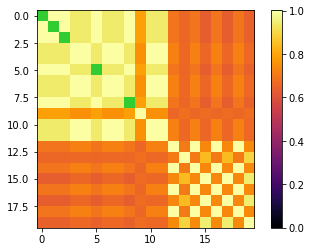

In [142]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

x = 100000
inferno = cm.get_cmap('inferno', x)
green = np.array([50/256, 205/256, 50/256, 1])
new_colours = np.vstack((inferno(np.linspace(0, 1, x)), green))
new_cmap = ListedColormap(new_colours, name='inferno-green')
plt.imshow(df_rows, cmap=new_cmap, vmin=0, vmax=cor_val)
plt.colorbar()
plt.show()

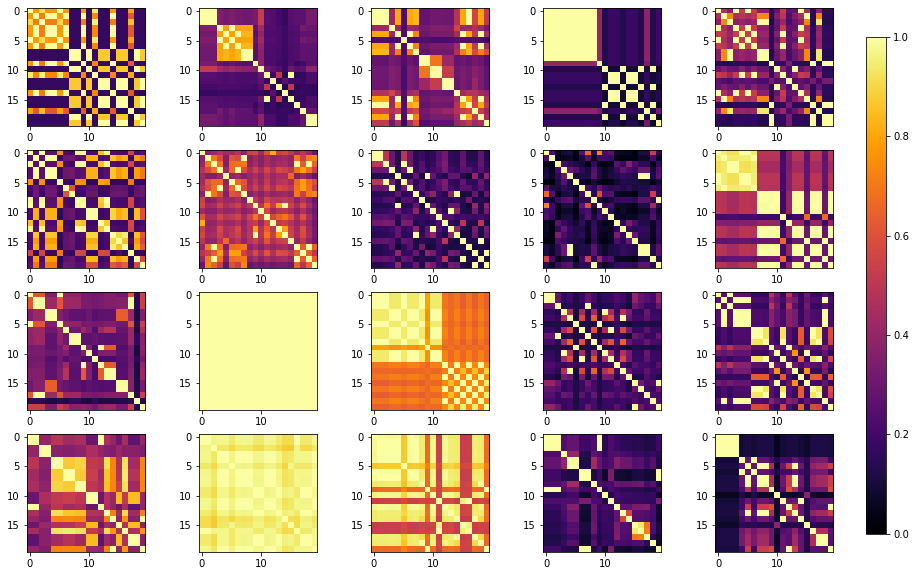

In [132]:
fig, axs = plt.subplots(4, 5, figsize=(14,10))
for i, ax in enumerate(axs.flat):
    im = ax.imshow(similarity_matrices[i], cmap='inferno', vmin = 0, vmax = 1)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.69])
fig.colorbar(im, cax=cbar_ax)

plt.show()

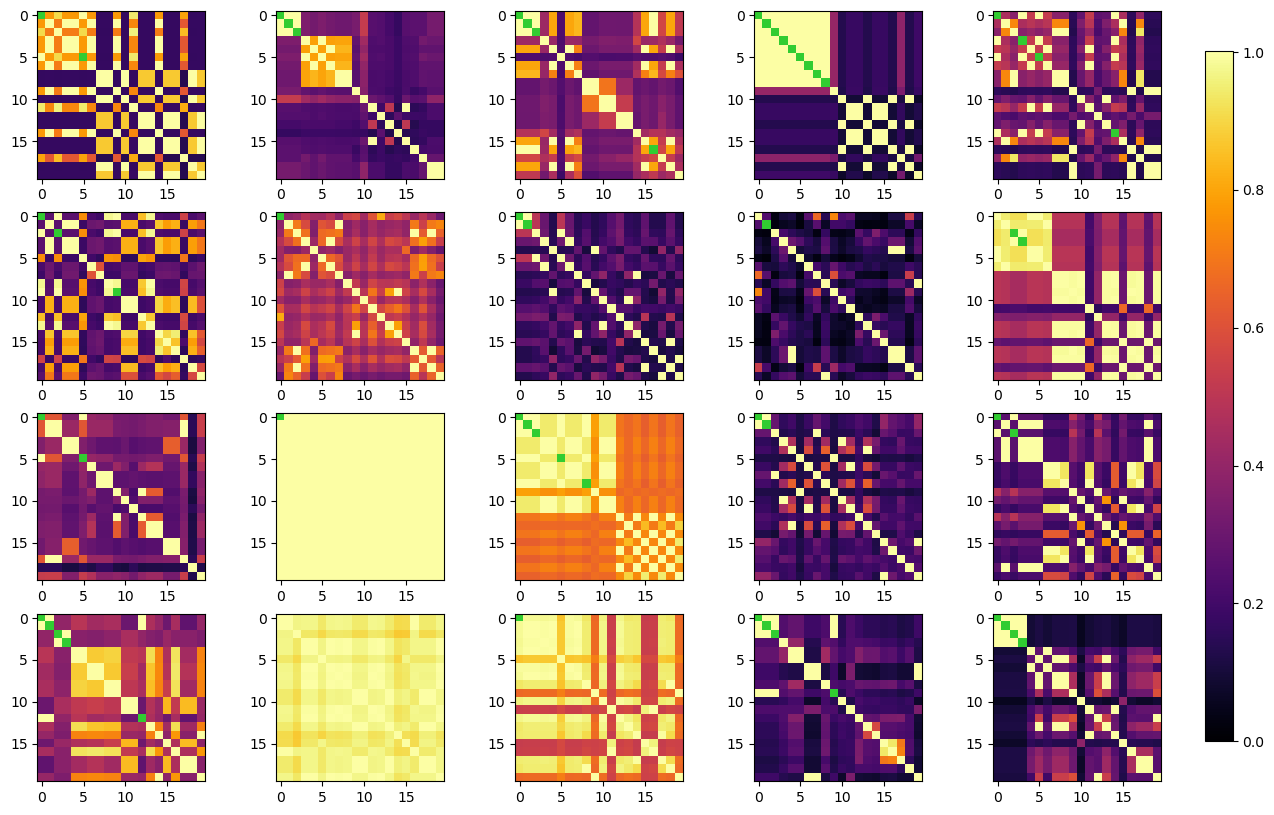

In [211]:
fig, axs = plt.subplots(4, 5, figsize=(14,10))
for i, ax in enumerate(axs.flat):
    im = ax.imshow(similarity_matrices_cor[i], cmap=new_cmap, vmax=cor_val, vmin=0)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.69])
fig.colorbar(im, cax=cbar_ax)

plt.show()
plt.close()

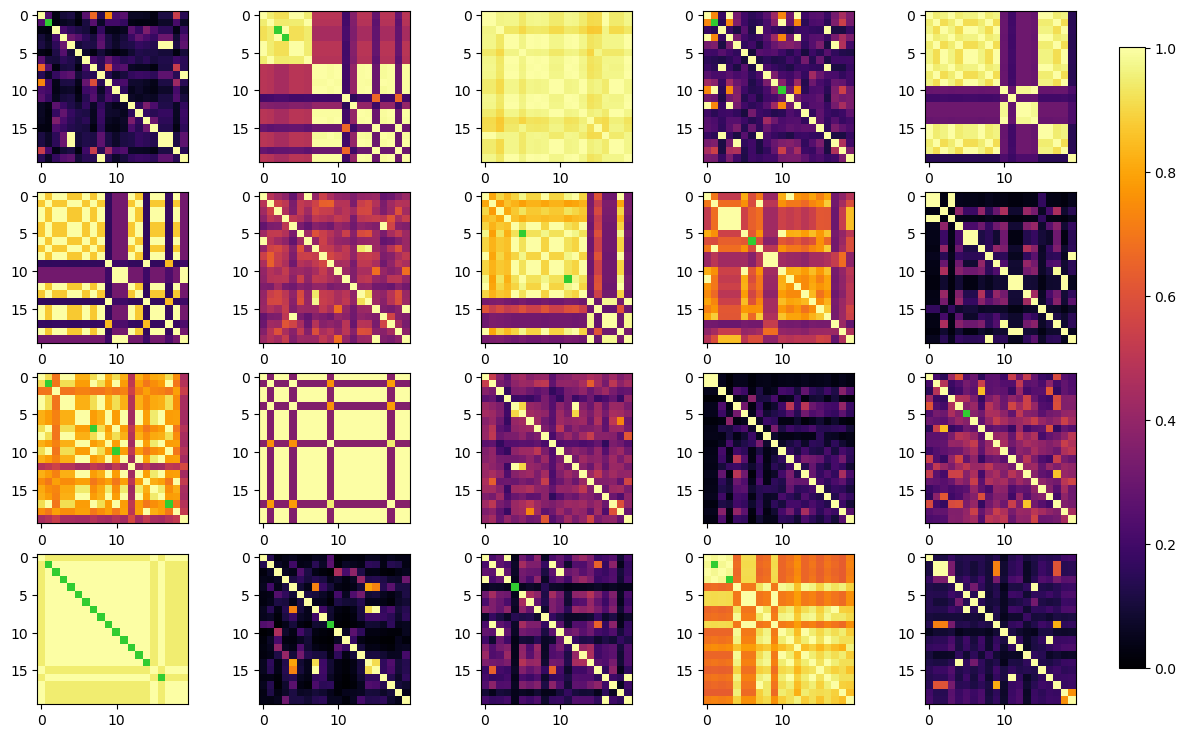

In [223]:
#same plot but only the ones where the top hit is not the true hit
plt.style.use('default')
fig, axs = plt.subplots(4, 5, figsize=(13,9))
for i, ax in enumerate(axs.flat):
    im = ax.imshow(similarity_matrices_cor[ids_top_false_hits_thresh[i]], cmap=new_cmap, vmax=cor_val, vmin=0)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.69])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [9]:
outfile = os.path.join(path_data, 'rfreg_all_match_perc_pmass.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        rfreg_all_match_perc_pmass = pickle.load(inf)

outfile = os.path.join(path_data, 'found_matches_s2v_match_perc_pmass_sim.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        found_matches_s2v_match_perc_pmass_sim = pickle.load(inf)

C:\Users\joris\Documents\eScience_data\data\rfreg_all_match_perc_pmass.pickle
C:\Users\joris\Documents\eScience_data\data\found_matches_s2v_match_perc_pmass_sim.pickle


In [226]:
found_matches_s2v_match_perc_pmass_sim[8].sort_values(by=['s2v_score'], ascending = False).iloc[:40]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,mass_match,s2v_score,label,perc_mass_change,parent_mass,similarity
63644,4.746049e-01,4,0.474605,4,1.0,0.480207,0,0.847510,116.992724,0.240385
64360,4.674166e-01,6,0.467438,7,1.0,0.463698,1,0.678008,117.192724,1.000000
66640,3.027054e-01,1,0.302705,1,0.0,0.442751,0,57.630672,185.992724,0.026567
64027,8.221855e-01,2,0.822186,2,0.0,0.438960,0,72.885850,203.992724,0.056711
63322,2.663150e-01,1,0.266315,1,0.0,0.379661,0,160.179369,306.992724,0.071233
63919,8.439887e-03,2,0.012535,2,0.0,0.365428,0,22.882767,144.992724,0.021818
64380,8.442114e-01,2,0.844212,3,0.0,0.354063,0,108.650768,246.192724,0.112540
62877,9.540146e-03,1,0.009540,1,1.0,0.353165,0,0.000000,117.992724,0.252427
66700,1.447068e-02,1,0.022203,2,0.0,0.352218,0,38.137945,162.992724,0.068720
63089,0.000000e+00,0,0.004762,2,0.0,0.341212,0,24.577787,146.992724,0.200000


In [11]:
#visualise tanimoto score of query vs match per position
topn = 20
all_similarities = []
for ID in range(len(found_matches_s2v_match_perc_pmass_sim)):
    df_select = found_matches_s2v_match_perc_pmass_sim[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    simil = df_select['similarity']
    all_similarities.append(list(simil))

In [12]:
per_pos = list(zip(*all_similarities))
#print(per_pos)
means = list(map(np.mean, per_pos))
stdevs = list(map(np.std, per_pos))

<BarContainer object of 20 artists>

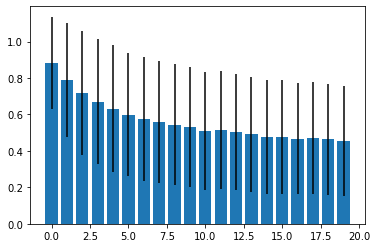

In [13]:
plt.bar(range(len(means)), means, yerr = stdevs)

In [138]:
#for each best true hit, how many connections > 0.6 does it have?
topn = 20
ID=0
cutoff = 0.6
amount_sims = []
for ID in range(len(found_matches_s2v_match_perc_pmass_sim)):
    df_select = found_matches_s2v_match_perc_pmass_sim[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    true_positives = [i for i, lab in enumerate(df_select['label']) if lab == 1]
    try:
        true_pos = true_positives[0] #take top hit
    except IndexError:
        amount_sim = -1 #true positive can't be found in topn
    else:
        amount_sim = len(similarity_matrices[ID][similarity_matrices[ID][true_pos] > cutoff])
    #report max cases
    #if amount_sim == 20:
        #print(ID)
    amount_sims.append(amount_sim)

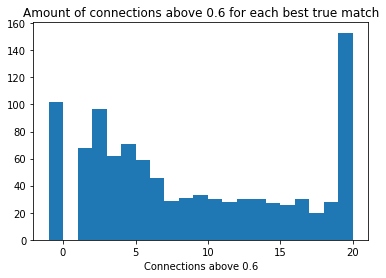

In [110]:
plt.hist(amount_sims, bins = range(-1, max(amount_sims)+1))
plt.xlabel('Connections above 0.6')
plt.title('Amount of connections above 0.6 for each best true match')
plt.show()

In [221]:
#if top hit is not true match, what is the average similarity of top hit above a threshold?
topn = 20
threshold = 0.4
false_m_simils_thresh = []
ids_top_false_hits_thresh = []
for ID in range(len(found_matches_s2v_match_perc_pmass_sim)):
    df_select = found_matches_s2v_match_perc_pmass_sim[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    df_select = df_select[(df_select['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        top_hit = df_select.iloc[0]
        if top_hit['label'] == 0:
            false_m_simil = top_hit['similarity']
            print(ID,false_m_simil)
            ids_top_false_hits_thresh.append(ID)
            false_m_simils_thresh.append(false_m_simil)
print(len(false_m_simils_thresh))

8 0.2403846153846154
9 0.9194865810968494
16 0.8412371134020619
22 0.7375
26 0.3267909715407262
40 0.18181818181818182
42 0.45215869311551926
46 0.9715639810426541
48 0.5869191049913941
49 0.054187192118226604
51 0.9177489177489178
52 0.3597014925373134
57 0.5076645626690712
61 0.047409040793825796
65 0.2460431654676259
66 0.9473684210526315
74 0.24050632911392406
79 0.04966139954853273
85 0.9792122538293216
86 0.14160401002506265
88 0.8095238095238095
89 0.10071942446043165
92 1.0
95 0.9693530079455165
96 0.4790697674418605
97 0.29707112970711297
98 1.0
104 1.0
105 0.9194476409666283
115 0.6427406199021207
116 0.7189655172413794
119 0.8018494055482166
128 0.9015486725663717
132 0.9971374045801527
135 0.9919839679358717
136 0.3629081947011707
138 0.9522709776751347
145 0.4662613981762918
147 0.20631067961165048
150 0.5722145804676754
153 1.0
154 0.9902755267423015
157 0.4552090245520902
158 0.5613249776186213
166 0.15494296577946767
167 0.20911528150134048
169 0.8957345971563981
172 0.

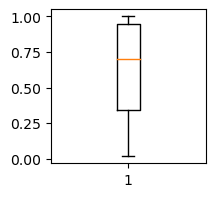

,avg_similarity_false_top_hit
count,263.000000
mean,0.629614
std,0.327008
min,0.018072
25%,0.342938
50%,0.698473
75%,0.949266
max,1.000000


In [222]:
plt.figure(figsize=(2,2))
plt.boxplot(false_m_simils_thresh)
plt.show()
plt.close()
pd.DataFrame(false_m_simils_thresh, columns = ['avg_similarity_false_top_hit']).describe()

In [147]:
found_matches_s2v_info_connections = []
cutoff = 0.6
connections = [] #list of lists, just the connections column for each query
for ID in range(len(found_matches_s2v_match_perc_pmass_sim)):
    df_select = found_matches_s2v_match_perc_pmass_sim[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    sim_matrix_select = similarity_matrices[ID]
    amount_sims = []
    for inner_ID in range(df_select.shape[0]):
        amount_sim = len(sim_matrix_select[sim_matrix_select[inner_ID] > cutoff])
        amount_sims.append(amount_sim)
    new_df = df_select.copy()
    new_df['connections'] = amount_sims
    connections.append(amount_sims)
    found_matches_s2v_info_connections.append(new_df)

In [148]:
found_matches_s2v_info_connections[13]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,mass_match,s2v_score,label,perc_mass_change,parent_mass,similarity,connections
77858,0.653871,103,0.653871,103,1.0,0.915145,1,0.000000,269.104724,1.000000,2
77859,0.815921,79,0.815921,79,1.0,0.859299,1,0.000000,269.104724,1.000000,2
69919,0.896335,55,0.896365,56,0.0,0.853750,0,6.692933,287.115724,0.288419,2
81380,0.969064,42,0.969064,42,1.0,0.851007,0,0.370488,268.107724,0.161074,2
71576,0.987751,51,0.986732,48,1.0,0.842918,0,0.370488,268.107724,0.198387,3
86964,0.876170,34,0.879715,34,0.0,0.836468,0,0.741719,271.100724,0.123853,2
71464,0.953082,71,0.954121,69,1.0,0.830731,0,0.370488,270.101724,0.180196,3
69918,0.806747,51,0.807096,55,0.0,0.818196,0,6.692933,287.115724,0.288419,2
70602,0.932597,37,0.932548,35,1.0,0.809579,0,0.370488,268.107724,0.206022,5
86963,0.648677,28,0.653825,30,0.0,0.780006,0,0.741719,271.100724,0.123853,2


In [195]:
#make new score which is s2v_score * factor^connections
factor = 1.04
cor_scores = []
found_matches_s2v_info_new_score = []
for ID in range(len(found_matches_s2v_info_connections)):
    cur_connections = connections[ID]
    cur_df = found_matches_s2v_info_connections[ID].copy()
    s2v_scores = cur_df['s2v_score']
    cor_score = []
    for con, s2v_sc in zip(cur_connections, s2v_scores):
        new_score = s2v_sc * (factor ** con)
        cor_score.append(new_score)
    cor_scores.append(cor_score)
    cur_df['new_score'] = cor_score
    found_matches_s2v_info_new_score.append(cur_df)

In [343]:
found_matches_s2v_info_new_score[3]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,mass_match,s2v_score,label,perc_mass_change,parent_mass,similarity,connections,new_score
61637,1.000000,38,1.000000,38,1.0,1.000000,1,0.000000,286.084724,1.000000,9,1.423312
62117,0.710039,30,0.710039,30,1.0,0.882587,1,0.000000,286.084724,1.000000,9,1.256196
61638,0.710039,30,0.710039,30,1.0,0.882587,1,0.000000,286.084724,1.000000,9,1.256196
62116,0.461954,17,0.461954,17,1.0,0.854334,1,0.000000,286.084724,1.000000,9,1.215984
61636,0.461954,17,0.461954,17,1.0,0.854334,1,0.000000,286.084724,1.000000,9,1.215984
61639,0.536247,24,0.536247,24,1.0,0.723554,1,0.000000,286.084724,1.000000,9,1.029843
62118,0.536247,24,0.536247,24,1.0,0.723554,1,0.000000,286.084724,1.000000,9,1.029843
62115,0.178749,7,0.178749,7,1.0,0.684594,1,0.000000,286.084724,1.000000,9,0.974391
61635,0.178749,7,0.178749,7,1.0,0.684594,1,0.000000,286.084724,1.000000,9,0.974391
12123,0.369597,18,0.369597,18,1.0,0.559346,0,0.000350,286.083724,0.405584,1,0.581720


In [197]:
#testing new_score + mass
#look at top20
test_m_s2v_top20 = []
test_m_new_score_top20 = []
threshold = 0.4
topn = 20 #only look at top 20

for ID in range(len(documents_query_s2v)):
    inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    current_match = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    # Scenario 2: mass + Spec2Vec + threshold
    df_select = current_match[(current_match['mass_match'] == 1)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_m_s2v_top20.append(best_bet)
    
    # Scenario 2: mass + new_score + threshold
    current_match_new = found_matches_s2v_info_new_score[ID].sort_values(by=['new_score'], ascending=False).iloc[:topn]
    df_select = current_match_new[(current_match_new['mass_match'] == 1)
                                  & (current_match_new['new_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_m_new_score_top20.append(best_bet)


#make arrays from lists
test_m_s2v_arr_top20 = np.array(test_m_s2v_top20)
test_m_new_score_arr_top20 = np.array(test_m_new_score_top20)

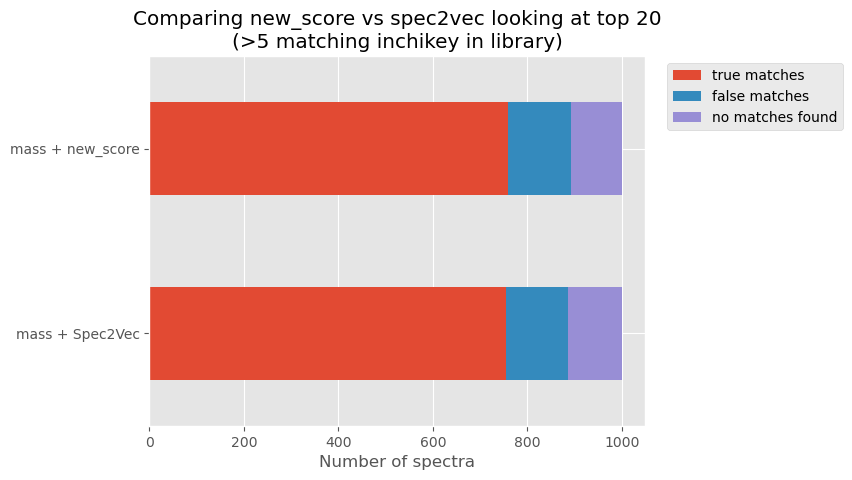

In [212]:
plt.style.use('ggplot')

ylabels = ['mass + Spec2Vec',
           'mass + new_score',]
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_m_s2v_arr_top20 == 1), np.sum(test_m_s2v_arr_top20 == 0), np.sum(test_m_s2v_arr_top20 == -1)],
                 [np.sum(test_m_new_score_arr_top20 == 1), np.sum(test_m_new_score_arr_top20 == 0), np.sum(test_m_new_score_arr_top20 == -1)]])

dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Comparing new_score vs spec2vec looking at top 20\n(>5 matching inchikey in library)')
#plt.figure(figsize=(5,5))
plt.show()

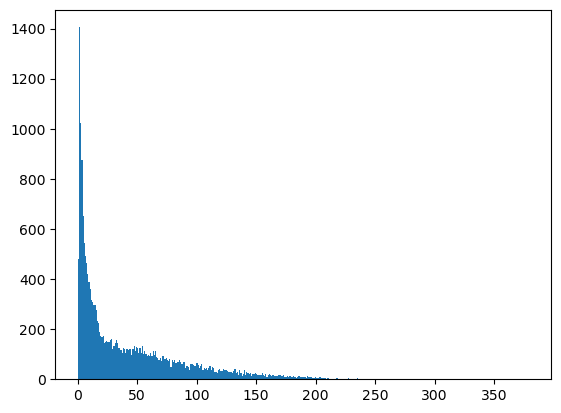

In [243]:
#visualise mod_cosine_matches for all top20 results
mod_cosine_matches = [elem for ID in range(len(found_matches_s2v_info_new_score)) for elem in list(found_matches_s2v_info_new_score[ID]['mod_cosine_matches'])]
plt.hist(mod_cosine_matches, bins = max(mod_cosine_matches)+1)
plt.show()

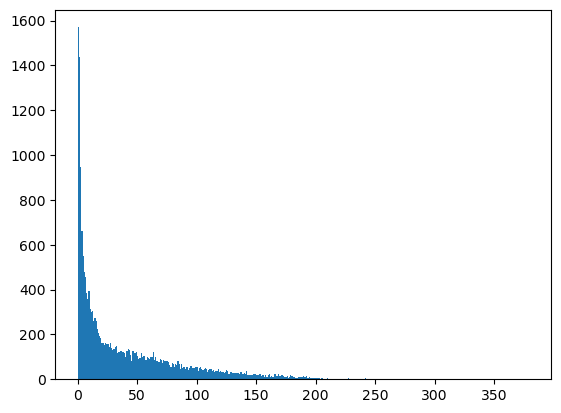

In [244]:
#visualise cosine_matches for all top20 results
cosine_matches = [elem for ID in range(len(found_matches_s2v_info_new_score)) for elem in list(found_matches_s2v_info_new_score[ID]['cosine_matches'])]
plt.hist(cosine_matches, bins = max(cosine_matches)+1)
plt.show()

In [345]:
#
[(i,1-0.93**i) for i in range(39)][-1]

(38, 0.9365616256969365)

In [321]:
def transform_num_matches(input_df, exp = 0.93):
    '''Transform the cosine_matches and mod_cosine_matches to between 0-1
    
    input_df: pandas DataFrame, spec2vec matches for one query
    exp: int, the base for the exponential, default: 0.93
    
    Both matches are transformed to between 0-1 by doing 1-0.93^num_matches
    '''
    df = input_df.copy() #otherwise it edits the df outside the function
    df['cosine_matches'] = [(1-0.93**i) for i in df['cosine_matches']]
    df['mod_cosine_matches'] = [(1-0.93**i) for i in df['mod_cosine_matches']]
    return df

In [350]:
#get max parent mass to make it relative
all_parent_masses = [elem for ID in range(len(found_matches_s2v_match_perc_pmass_sim)) for elem in list(found_matches_s2v_match_perc_pmass_sim[ID]['parent_mass'])]
max_parent_mass = max(all_parent_masses)
max_parent_mass

1913.4927235480093

In [439]:
#preprocess for neural network, remove mass_match, make number of matches and parent_mass relative and let s2v_score start at 0
#also divide perc_mass_change by 100 to make it a fraction instead of percentage
nn_prep_found_matches_s2v_match_perc_pmass_sim = []
for ID in range(len(found_matches_s2v_match_perc_pmass_sim)):
    current = found_matches_s2v_match_perc_pmass_sim[ID].copy()
    current = transform_num_matches(current)
    current['parent_mass'] = [cur_pm/max_parent_mass for cur_pm in current['parent_mass']]
    current.drop(['mass_match'], axis=1, inplace=True)
    current['s2v_score'] = [0 if score < 0 else score for score in current['s2v_score']] #let it start at 0
    current['perc_mass_change'] = [elem/100 for elem in current['perc_mass_change']]
    nn_prep_found_matches_s2v_match_perc_pmass_sim.append(current)

In [440]:
nn_prep_found_matches_s2v_match_perc_pmass_sim[3].sort_values(by=['s2v_score'], ascending=False)

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,perc_mass_change,parent_mass,similarity
61637,1.000000,0.936562,1.000000,0.936562,1.000000,1,0.000000,0.149509,1.000000
62117,0.710039,0.886633,0.710039,0.886633,0.882587,1,0.000000,0.149509,1.000000
61638,0.710039,0.886633,0.710039,0.886633,0.882587,1,0.000000,0.149509,1.000000
62116,0.461954,0.708787,0.461954,0.708787,0.854334,1,0.000000,0.149509,1.000000
61636,0.461954,0.708787,0.461954,0.708787,0.854334,1,0.000000,0.149509,1.000000
...,...,...,...,...,...,...,...,...,...
69629,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000329,0.149558,0.279911
24366,0.000000,0.000000,0.000610,0.135100,0.000000,0,0.000378,0.149566,0.211832
58063,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.002933,0.149071,0.280880
58068,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.002933,0.149071,0.280880


In [441]:
#finalising data for nn, add label 1 if similarity is above cutoff
sim_cutoff = 0.6
nn_found_matches_s2v_match_perc_pmass_sim = nn_prep_found_matches_s2v_match_perc_pmass_sim[0]\
    .append(nn_prep_found_matches_s2v_match_perc_pmass_sim[1:])\
    .drop(['label'], axis = 1)
simlabs = [1 if sim >= sim_cutoff else 0 for sim in nn_found_matches_s2v_match_perc_pmass_sim['similarity']]
nn_found_matches_s2v_match_perc_pmass_sim['sim_label'] = simlabs
nn_found_matches_s2v_match_perc_pmass_sim.drop(['similarity'], axis = 1, inplace = True)
nn_found_matches_s2v_match_perc_pmass_sim.sort_values(by='s2v_score', ascending = False)

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,perc_mass_change,parent_mass,sim_label
65637,1.000000,0.549896,1.000000,0.549896,1.0,0.000000,0.099886,1
40198,1.000000,0.931787,1.000000,0.931787,1.0,0.000000,0.412700,1
40059,1.000000,0.996990,1.000000,0.996990,1.0,0.000000,0.435113,1
69565,1.000000,0.663299,1.000000,0.663299,1.0,0.000000,0.441238,1
66426,1.000000,0.980135,1.000000,0.980135,1.0,0.000000,0.105622,1
...,...,...,...,...,...,...,...,...
26180,0.000132,0.251948,0.000132,0.251948,0.0,0.000398,0.211285,0
26442,0.000094,0.135100,0.000094,0.135100,0.0,0.000396,0.211285,0
26952,0.000095,0.135100,0.000095,0.135100,0.0,0.000396,0.211285,0
61049,0.000056,0.195643,0.000056,0.195643,0.0,0.002309,0.211689,0


In [442]:
#loading second test set to test nn output
outfile = os.path.join(path_data, 'new_found_matches_s2v_match_perc_pmass_sim.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_found_matches_s2v_match_perc_pmass_sim = pickle.load(inf)

#preprocess for neural network, remove mass_match, make number of matches and parent_mass relative and let s2v_score start at 0
nn_prep_new_found_matches_s2v_match_perc_pmass_sim = []
for ID in range(len(new_found_matches_s2v_match_perc_pmass_sim)):
    current = new_found_matches_s2v_match_perc_pmass_sim[ID].copy()
    current = transform_num_matches(current)
    current['parent_mass'] = [cur_pm/max_parent_mass for cur_pm in current['parent_mass']]
    current.drop(['mass_match'], axis=1, inplace=True)
    current['s2v_score'] = [0 if score < 0 else score for score in current['s2v_score']] #let it start at 0
    current['perc_mass_change'] = [elem/100 for elem in current['perc_mass_change']] #make a fraction instead of percentage
    nn_prep_new_found_matches_s2v_match_perc_pmass_sim.append(current)

#finalising data for nn, add label 1 if similarity is above cutoff
sim_cutoff = 0.6
nn_new_found_matches_s2v_match_perc_pmass_sim = nn_prep_new_found_matches_s2v_match_perc_pmass_sim[0]\
    .append(nn_prep_new_found_matches_s2v_match_perc_pmass_sim[1:])\
    .drop(['label'], axis = 1)
simlabs = [1 if sim >= sim_cutoff else 0 for sim in nn_new_found_matches_s2v_match_perc_pmass_sim['similarity']]
nn_new_found_matches_s2v_match_perc_pmass_sim['sim_label'] = simlabs
nn_new_found_matches_s2v_match_perc_pmass_sim.drop(['similarity'], axis = 1, inplace = True)
nn_new_found_matches_s2v_match_perc_pmass_sim.sort_values(by='s2v_score', ascending = False)

C:\Users\joris\Documents\eScience_data\data\new_found_matches_s2v_match_perc_pmass_sim.pickle


,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,perc_mass_change,parent_mass,sim_label
68321,1.000000,0.516018,1.000000,0.516018,1.0,0.000000,0.188767,1
7990,1.000000,0.999989,1.000000,0.999989,1.0,0.000000,0.163628,1
40101,1.000000,0.995976,1.000000,0.995976,1.0,0.000000,0.373963,1
25644,1.000000,0.999996,1.000000,0.999996,1.0,0.000000,0.178792,1
25645,1.000000,0.999996,1.000000,0.999996,1.0,0.000000,0.178792,1
...,...,...,...,...,...,...,...,...
2561,0.000000,0.000000,0.000851,0.135100,0.0,0.002433,0.192411,0
21534,0.000009,0.135100,0.000009,0.135100,0.0,0.000131,0.214915,0
25719,0.000000,0.000000,0.000000,0.000000,0.0,0.000187,0.237942,0
3847,0.000000,0.000000,0.000000,0.000000,0.0,0.002373,0.192423,0


In [443]:
#from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# split into input (X) and output (y) variables
X = nn_found_matches_s2v_match_perc_pmass_sim.drop('sim_label', axis = 1)
y = nn_found_matches_s2v_match_perc_pmass_sim['sim_label']
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=20)

Train on 239233 samples
Epoch 1/20
239233/239233 [==============================] - 17s 73us/sample - loss: 0.2047 - accuracy: 0.9302
Epoch 2/20
239233/239233 [==============================] - 15s 64us/sample - loss: 0.1894 - accuracy: 0.9343
Epoch 3/20
239233/239233 [==============================] - 15s 64us/sample - loss: 0.1873 - accuracy: 0.9351
Epoch 4/20
239233/239233 [==============================] - 15s 65us/sample - loss: 0.1858 - accuracy: 0.9354
Epoch 5/20
239233/239233 [==============================] - 15s 65us/sample - loss: 0.1842 - accuracy: 0.9355
Epoch 6/20
239233/239233 [==============================] - 16s 65us/sample - loss: 0.1832 - accuracy: 0.9356
Epoch 7/20
239233/239233 [==============================] - 16s 66us/sample - loss: 0.1824 - accuracy: 0.9357
Epoch 8/20
239233/239233 [==============================] - 15s 65us/sample - loss: 0.1819 - accuracy: 0.9358
Epoch 9/20
239233/239233 [==============================] - 16s 65us/sample - loss: 0.1815 - acc

In [444]:
X_test = nn_new_found_matches_s2v_match_perc_pmass_sim.drop(['sim_label'], axis = 1)
y_test = nn_new_found_matches_s2v_match_perc_pmass_sim['sim_label']
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

241054/241054 [==============================] - 9s 36us/sample - loss: 0.1755 - accuracy: 0.9360
Accuracy: 93.60


In [445]:
# make class predictions with the model
predictions_test = model.predict_classes(X_test)
# summarize the first 5 cases
for i in range(5):
    print('%s => %d (expected %d)' % (X_test.iloc[i].tolist(), predictions_test[i], y_test.iloc[i]))

[0.0, 0.0, 0.013467988189490118, 0.06999999999999995, 0.07353126310680858, 0.0008183397545844823, 0.4339748530677778] => 0 (expected 0)
[0.0, 0.0, 0.0, 0.0, 0.10153172453806047, 0.0008388283787788562, 0.43398373734509477] => 0 (expected 0)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0007833885721353689, 0.43395969753588415] => 0 (expected 0)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0008291866732756052, 0.4339795565087103] => 0 (expected 0)
[0.0, 0.0, 0.0, 0.0, 0.09115114409548597, 0.000836417952402975, 0.4339826921359986] => 0 (expected 0)


In [446]:
nn_new_testset_tested = []
for ID in range(len(nn_prep_new_found_matches_s2v_match_perc_pmass_sim)):
    current_match = nn_prep_new_found_matches_s2v_match_perc_pmass_sim[ID].copy()
    simlabs = [1 if sim >= sim_cutoff else 0 for sim in current_match['similarity']]
    predict_on = current_match.drop(['label', 'similarity'], axis = 1)
    predictions = model.predict_classes(predict_on)
    current_match['predictions'] = predictions
    correct_guess = [pred == lab for pred, lab in zip(predictions, simlabs)]
    current_match['correct_guess'] = correct_guess
    nn_new_testset_tested.append(current_match)

In [447]:
nn_new_testset_tested[0].sort_values(by=['s2v_score'], ascending=False).iloc[:20]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score,label,perc_mass_change,parent_mass,similarity,predictions,correct_guess
46341,0.792853,0.195643,0.792853,0.195643,0.838697,0,0.000000,0.433620,0.947368,1,[True]
52743,0.766401,0.070000,0.766401,0.070000,0.589020,0,0.086775,0.471248,0.901186,0,[False]
34539,0.241939,0.070000,0.955195,0.135100,0.585604,0,0.004859,0.435727,0.859649,1,[True]
47562,0.010289,0.070000,0.010289,0.070000,0.584888,1,0.000000,0.433620,1.000000,1,[True]
35469,0.243206,0.070000,0.243206,0.070000,0.565561,0,0.004859,0.435727,0.859649,1,[True]
33568,0.000000,0.000000,0.000000,0.000000,0.560947,0,0.002429,0.432567,1.000000,1,[True]
52554,0.000000,0.000000,0.000000,0.000000,0.551094,0,0.000000,0.433620,0.947368,1,[True]
47158,0.285278,0.135100,0.285278,0.135100,0.550833,0,0.028925,0.446163,1.000000,1,[True]
47558,0.032219,0.070000,0.032219,0.070000,0.548738,0,0.000000,0.433620,0.947368,1,[True]
38527,0.013670,0.070000,0.013693,0.135100,0.545742,0,0.002429,0.432567,1.000000,1,[True]


In [424]:
#if top hit is not true match, what is the average similarity of top hit above a threshold?
topn = 20
threshold = 0.4
new_false_m_simils_thresh = []
new_ids_top_false_hits_thresh = []
for ID in range(len(nn_new_testset_tested)):
    df_select = nn_new_testset_tested[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    df_select = df_select[(df_select['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        top_hit = df_select.iloc[0]
        if top_hit['label'] == 0:
            new_false_m_simil = top_hit['similarity']
            print(ID, new_false_m_simil)
            new_ids_top_false_hits_thresh.append(ID)
            new_false_m_simils_thresh.append(new_false_m_simil)
print(len(new_false_m_simils_thresh))

0 0.9473684210526315
6 1.0
7 0.9564315352697096
8 0.9243641231593038
9 0.9606986899563319
10 0.9859550561797753
11 0.1043360433604336
20 0.5894179894179894
24 0.47648261758691207
27 0.9954022988505747
28 0.9834905660377359
33 0.380143696930111
36 0.9022633744855967
38 0.9722863741339491
41 0.2834101382488479
43 1.0
44 1.0
50 0.41708542713567837
64 0.25815808556925307
65 1.0
66 0.9410609037328095
68 0.20887728459530025
77 0.3350189633375474
79 0.0840751730959446
82 0.9281481481481482
105 0.9122340425531915
109 1.0
112 0.8425531914893617
116 0.0877742946708464
118 0.39643652561247217
128 0.3782051282051282
134 0.9707207207207207
135 0.40821917808219177
137 1.0
138 0.9283088235294118
142 0.13793103448275862
143 0.1828978622327791
144 0.9265873015873016
149 1.0
150 0.9493087557603687
152 0.40606843124596514
164 0.4371816638370119
165 1.0
168 0.9795918367346939
174 0.6467625899280576
176 1.0
177 1.0
178 0.7666098807495741
183 0.9053254437869822
186 0.9090909090909091
188 0.9522776572668112


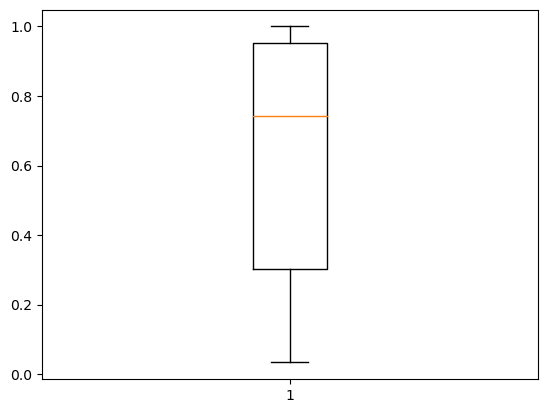

In [425]:
plt.boxplot(new_false_m_simils_thresh)
plt.show()

In [448]:
#testing if top hit is above 0.6 similarity after filtering with nn
#look at top20
test_sim_s2v_top20 = []
test_sim_filt_nn = []

threshold = 0.4
topn = 20 #only look at top 20
sim_threshold = 0.6

for ID in range(len(nn_new_testset_tested)):
    current_match = nn_new_testset_tested[ID].sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    
    #inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    #current_match = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    # Scenario 1: mass + Spec2Vec + threshold
    df_select = current_match[(current_match['perc_mass_change'] == 0)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        sim = df_select.iloc[0]['similarity'] #look at similarity of top hit
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_sim_s2v_top20.append(best_bet)
    
    # Scenario 2: Spec2Vec + threshold after filtering for non-similar matches with nn
    df_select = current_match[(current_match['perc_mass_change'] == 0)
                                  & (current_match['predictions'] == 1)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        sim = df_select.iloc[0]['similarity'] #look at similarity of top hit
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_sim_filt_nn.append(best_bet)


#make arrays from lists
test_sim_s2v_arr_top20 = np.array(test_sim_s2v_top20)
test_sim_filt_nn_arr = np.array(test_sim_filt_nn)

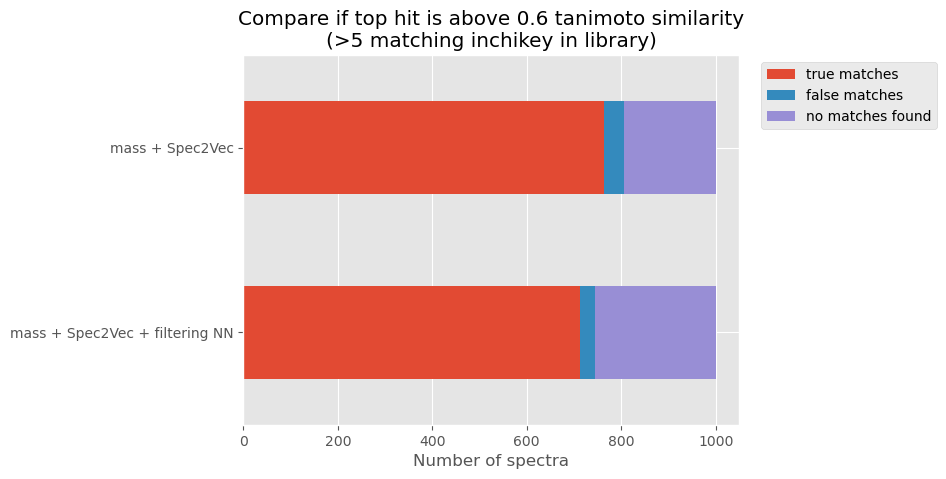

In [449]:
plt.style.use('ggplot')

ylabels = ['mass + Spec2Vec',
           'mass + Spec2Vec + filtering NN',]
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_sim_s2v_arr_top20 == 1), np.sum(test_sim_s2v_arr_top20 == 0), np.sum(test_sim_s2v_arr_top20 == -1)],
                 [np.sum(test_sim_filt_nn_arr == 1), np.sum(test_sim_filt_nn_arr == 0), np.sum(test_sim_filt_nn_arr == -1)]])

dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Compare if top hit is above 0.6 tanimoto similarity\n(>5 matching inchikey in library)')
#plt.figure(figsize=(5,5))
plt.show()